## Lab 1: Getting data from API's

A great source of data and Pandas practice is getting data from the Internet. It is not going to come in a .csv file, though: It will be a stream of records, typically in XML (eXtensible Mark-up Language) or JSON (JavaScript Object Notation) format.

We'll look at a very simple API and some useful code chunks for getting and analyzing data, and then you'll take a look at the APIs available from the Federal government as the main work for your lab.


## API Queries

The core programming skill of the activity is to learn to query an online Application Programmer Interface (API). It is a similar experience to browsing the Internet, and initial results can be displayed the web browser. When visiting a web page, the address bar typically contains something like
$$
\texttt{https://} \underbrace{\texttt{www.}}_{\text{World Wide Web subdomain}} \texttt{domain}. \underbrace{\texttt{tld}}_{\text{Top level domain}},
$$
where the https:// specifies the protocol, www. specifies the world-wide-web subdomain, the domain is the entity, and the top-level domain .tld is typically something like .com or .gov, but is increasingly varied as ICANN releases more TLD's into circulation.

With an online API, the user instead enters a url that goes directly to an API subdomain
$$
\texttt{https://} \underbrace{\texttt{api.}}_{\text{Application programmer interface}} \texttt{domain.tld}/ \texttt{(the query)}
$$
or accesses REST services as
$$
\texttt{https://www.domain.tld} \underbrace{\texttt{/REST}}_{\text{Accesses REST services}}/ \texttt{(the query)}
$$
This accesses data on the domain's servers and returns the result directly to the user.

The query itself is typically a string beginning with a question mark ?, followed by a series of expressions joined by ampersands &. For example,

`?ProductType=Phone\&Manufacturer=Apple`

passes a query requesting all records for which the product type is recorded as phone and the manufacturer is recorded as Apple. Some API's include date ranges and other, more complex requests.

To get started, a simple warm-up is to use the API from saferproducts.gov, which has a simple and intuitive structure for queries, and the results are simple enough to look at in the browser. Typing this in the address bar in a browser should yield about thirty records:

    https://www.saferproducts.gov/RestWebServices/Recall?format=json&ProductType=Phone  

with the first being, on this occasion:

    "RecallID": 7856,
    "RecallNumber": "16266",
    "RecallDate": "2016-09-15T00:00:00",
    "Description": "This recall involves the Samsung Galaxy Note7 smartphone sold before
    September 15, 2016. The recalled devices have a 5.7 inch screen and were sold in the
    following colors: black onyx, blue coral, gold platinum and silver titanium with a
    matching stylus. Samsung is printed on the top front of the phone and Galaxy Note7
    is printed on the back of the phone. To determine if your phone has been recalled,
    locate the IMEI number on the back of the phone or the packaging, and enter the IMEI
    number into the online registration site www.samsung.com or call Samsung toll-free
    at 844-365-6197.",
    "URL": "https://www.cpsc.gov/Recalls/2016/Samsung-Recalls-Galaxy-Note7-Smartphones",
    "Title": "Samsung Recalls Galaxy Note7 Smartphones Due to Serious Fire and Burn Hazards",
    "ConsumerContact": "Contact your wireless carrier or place of purchase, call Samsung
    toll-free at 844-365-6197 anytime, or go online at www.samsung.com.",
    "LastPublishDate": "2016-10-27T00:00:00"

The query itself in this case is:

    ?format=json&ProductType=Phone  

The quert requests all of the recalls in JavaScript Object Notation (json) format, where the `ProductType` variable is equal to `Phone`. In addition to `ProductType`, other options include:

    RecallID,
    RecallNumber,
    RecallDateStart,
    RecallDateEnd,
    RecallURL,
    LastPublishDateStart,
    LastPublishDateEnd,
    RecallTitle,
    ConsumerContact,
    RecallDescription,
    ProductName,
    ProductDescription,
    ProductModel,
    ProductType,
    InconjunctionURL,
    ImageURL,
    Injury,
    Manufacturer,
    Retailer,
    Importer,
    Distributor,
    ManufacturerCountry,
    UPC,
    Hazard,
    Remedy,
    RemedyOption

**1. Practice writing queries using the saferproducts.gov API and your web browser.**

In [1]:
https://www.saferproducts.gov/RestWebServices/Recall?format=json&ProductType=Toys

https://www.saferproducts.gov/RestWebServices/Recall?format=json&ProductType=Phone\&Manufacturer=Samsung

https://www.saferproducts.gov/RestWebServices/Recall?format=json&ProductType=Laptop

https://www.saferproducts.gov/RestWebServices/Recall?format=json&ProductType=TV

SyntaxError: invalid syntax (<ipython-input-1-25201b5d8a0d>, line 1)

## Wrangling the Data

Piping the data to Pandas is easy, because the preceding code chunk put the JSON data into a native Python dictionary, and the following converts it to a dataframe:

    df = pd.DataFrame.from_dict(data)

If the data is in raw XML or JSON format --- which might especially be true with other API's --- it would instead be \texttt{pd.read\_xml(data)} or \texttt{pd.read\_json(data)}. Ironing out these details in advance for other applications is a key part of the presentation for students, but having students resolve these issues as a component of group work or an assignment is a great way to help them mature as coding problem solvers by struggling with documentation and a well-defined problem.

Unfortunately, there aren't many non-text fields in the \texttt{www.saferproducts.gov} data. However, there are a few fields of interest that can be tabulated and discussed, such as RemedyOptions and ManufacturerCountries:

    df['RemedyOptions'].value_counts()

with output

    RemedyOptions
    []                                                                               139
    [{'Option': 'Repair'}]                                                            49
    [{'Option': 'Replace'}]                                                           12
    [{'Option': 'Refund'}]                                                             7
    [{'Option': 'Replace'}, {'Option': 'Repair'}]                                      4
    [{'Option': 'Refund'}, {'Option': 'Replace'}, {'Option': 'Repair'}]                1
    [{'Option': 'Replace'}, {'Option': 'Refund'}]                                      1
    [{'Option': 'Refund'}, {'Option': 'Repair'}]                                       1
    [{'Option': 'Label'}]                                                              1
    [{'Option': 'New Instructions'}, {'Option': 'Replace'}, {'Option': 'Refund'}]      1
    Name: count, dtype: int64

It's appropriate at this point to do some data cleaning, particularly by flattening dictionary entries. With response data that get converted from json to a dictionary, there are often values in the data frame that need to be flattened or unpacked. For example, some values are recorded as \texttt{ [$\{$'Country':'Canada'$\}$]}, or, worse, a dictionary with multiple entries: \texttt{[ $\{$ 'Option': 'Replace'$\}$, $\{$'Option': 'Repair'$\}$]  ] }. This can lead to problems when another package refuses to work with a lists of lists or doesn't know how to simplify a dictionary to data, and presents some conceptual questions when cleaning.

A simple script to recursively collapse the dictionary entries into a single string is:

    temp = df['RemedyOptions']
    clean_values = []
    for i in range(len(temp)):
        if len(temp[i])>0:
            values = []
            for j in range(len(temp[i])):
                values.append(temp[i][j]['Option'] )
            clean_values.append(values)
        else:
            clean_values.append('')
    df['remedy'] = clean_values

**3. Convert this code chunk into a function you can reuse to flatten dictionaries, or explain clearly the problems you run into while attempting to do so. Make some tables or plots.**


FlattenedRemedy
                           1
Repair                     1
Replace                    1
Refund, Replace, Repair    1
Label                      1
Name: count, dtype: int64


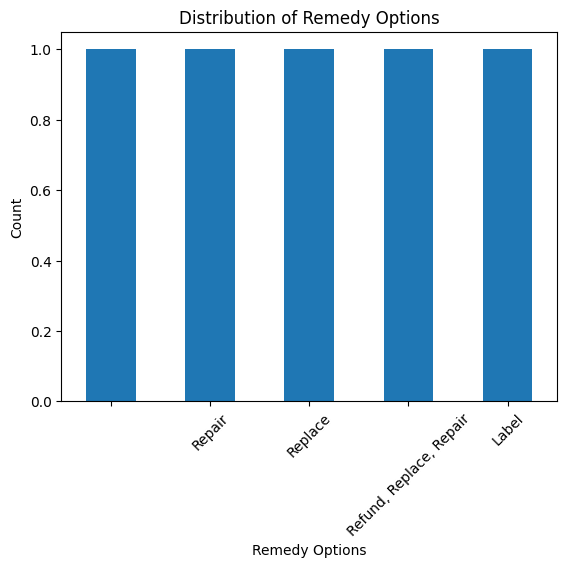

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def flatten_column(column):

  clean_values =[]

  for i in range(len(column)):
    if len(column[i]) > 0:
      values =[]
      for j in range(len(column[i])):
        if 'Option' in column[i][j]:
          values.append(column[i][j]['Option'])
      clean_values.append(", ".join(values))
    else:
      clean_values.append('')

  return pd.Series(clean_values)

data = {
    'RemedyOptions': [
        [],
        [{'Option': 'Repair'}],
        [{'Option': 'Replace'}],
        [{'Option': 'Refund'}, {'Option': 'Replace'}, {'Option': 'Repair'}],
        [{'Option': 'Label'}]
    ]
}
df = pd.DataFrame(data)
df

df['FlattenedRemedy'] = flatten_column(df['RemedyOptions'])
df

#summary table generation
remedy_counts = df['FlattenedRemedy'].value_counts()
print(remedy_counts)
# plotting bar chart
remedy_counts.plot(kind='bar', title='Distribution of Remedy Options')
plt.xlabel('Remedy Options')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## Accessing API's with Python

Anytime you use a computer to access resources on the Internet, you will likely run into problems. There are many options, but two with low coding overhead: The `requests` and `urrlib.requests` packages.

The following code chunk uses the `requests` package to get the same kind of data that was being displayed in the browser, but in an interactive Python session:

    import requests
    url = 'https://www.saferproducts.gov/RestWebServices/' # Location of the API
    query = 'Recall?format=json&ProductType=Exercise' # The query
    header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0)
        Gecko/20100101 Firefox/124.0'} # The user-agent to avoid being blocked
    raw = requests.get(url+query,headers=header) # Query the database
    data = raw.json() # Convert data from json to dictionary

To make the code easier to read, it separates the url and the query into two different strings, then concatenates them in the GET request. This makes it easier to edit the query, as well as suggests a simple way to loop over a number of queries that might be sent to the same API.

Many resources are designed to block access from particular kinds of users. In order to circumvent these obstacles, you can specify a `header` dictionary that presents the query to the server as coming from a hypothetical and common user. In this case, the header presents the query as coming from a Firefox browser from a Windows computer, rather than something like `python-requests/3.12.1`. This problem appears generally in scraping data from the web, and can grind the process to a halt. For whatever reason, I have been blocked and gotten 403 errors with the `requests` package, which motivated me to prepare a second alternative that seems more robust:

    import urllib.request
    import json
    url = 'https://www.saferproducts.gov/RestWebServices/' # Location of the API
    query = 'Recall?format=json&ProductType=Exercise' # The query
    response = urllib.request.urlopen(url+query)
    response_bytes = response.read()
    data = json.loads(response_bytes) # Convert response to json
    response.close()

This is a bit more code and some steps are a bit less human-friendly, but seems to work a bit more reliably than `requests`.

**2. Practice with the saferproducts.gov API and the above code in a notebook to see how API's work, in general.**

In [10]:
import requests
import pandas as pd


url = 'https://www.saferproducts.gov/RestWebServices/'  # Base API URL
query = 'Recall?format=json&ProductType=Exercise'  # Query for product type 'Exercise'


header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}


response = requests.get(url + query, headers=header)

if response.status_code == 200:
    # Convert the response to JSON format (Python dictionary)
    data = response.json()

    # Display first record
    print(data[0])
else:
    print(f"Error: {response.status_code}")

#convert JSON to pandas
df = pd.DataFrame(data)
df.head()

Error: 403


,RemedyOptions
0,[]
1,[{'Option': 'Repair'}]
2,[{'Option': 'Replace'}]
3,"[{'Option': 'Refund'}, {'Option': 'Replace'}, ..."
4,[{'Option': 'Label'}]


## Dashboarding the Results (Optional)

To complete the pipeline from data to product, we can use \texttt{streamlit} to quickly convert Python code into a web page that can be accessed locally. This can be done with essentially three lines of code: An import statement, a $.title()$ method call to set the page title, and an $.write()$ call to push the results to the page. Although relatively static, completing this step serves a pedogogical and psychological purpose: It pivots the students to thinking about how to communicate results to an audience, and how the project could become an ongoing endeavor rather than a single analytical exercise.

The entire .py file to create the dashboard is

    import pandas as pd
    import requests
    import streamlit as st
    # Conduct analysis:
    url = 'https://www.saferproducts.gov/RestWebServices/Recall'
    query = '?format=json&RecallTitle=Gas'
    header = {'User-Agent':
              'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
    raw = requests.get(url+query,headers=header)
    data = raw.json()
    df = pd.DataFrame.from_dict(data)
    temp = df['RemedyOptions']
    clean_values = []
    for i in range(len(temp)):
        if len(temp[i])>0:
            values = []
            for j in range(len(temp[i])):
                values.append(temp[i][j]['Option'] )
            clean_values.append(values)
        else:
            clean_values.append('')
    df['remedy'] = clean_values
    remedy_counts = df['remedy'].value_counts()
    # Create streamlit output:
    st.title('Remedy Statistics')
    st.write(remedy_counts)

To create the web page, run the following at the command line:

    streamlit run remedy.py

This should convert the above analysis into a web page available from localhost.

**4. Produce your own table or plot, and output it to streamlit.**

optional question

## Other API Sources

Valuable and interesting Federal API resources are listed at:

    https://catalog.data.gov/dataset/?_res_format_limit=0&res_format=API

and in the future will likely easily be found at \texttt{data.gov}. Some highlights include:

- CDC WONDER API for Data Query Web Service: Includes death certificates with causes since approximately the 1990's.
- Comprehensive Housing Affordability Strategy (CHAS): Housing and Urban Development (HUD) maintains an API that provides Census data on housing problems and needs unavailable through other sources, including IPUMS.
- Federal Election Commission API: Provides historical and up to the minute campaign finance data.
- Toxic Release Inventory: Provided by the Environmental Protection Agency, this API documents the release and management of over 800 toxic substances, reported annually by privately owned facilities and the government.
- Petroleum Data, Prices: Provides prices of petroleum products and crude oil at weekly, monthly, and yearly time scales.
- Fair Market Rents Lookup tool: Fair Market Rents (FMRs) determine the value of housing vouchers for Section 8 renters. This API provides the FMR values and other measures of housing affordability.
- Annual Economic Surveys, Business Patterns: Surveys of businesses at the zip code level, tracking economic sentiment and activity.
- Food Access Research Atlas: Provides spatial data on food access and the availability of supermarkets within census tracts. Can be merged with census data to look at under-served populations and food deserts.
- National Oceanographic and Atmospheric Administration: Provides API access to data on real time weather and climate change projections.

Each of these API resources could either be the cornerstone of a project or a source of additional data. These data sources have a number of advantages: They're free, most of them can be accessed using the same API key, and most have similar documentation for how to write a query. This is ideal for students to iterate, experiment, and take risks, with little cost to failure.

In addition to government data, many commerical apps provide API access to developers and researchers. AirBnB, Amazon, Reddit, eBay, X, and many others maintain API access to develop third-party apps. These opportunities present many advantages: The data are larger, have more variety, and there are vastly many more cases. Building a third-party app that includes analytics could easily consume an entire semester and open a variety of applications in predictive analytics, natural language processing, and generative AI (e.g. predict which reviews are fake or real for Amazon for a product group like ``women's watches', and then make recommendations for different price points). While an exciting possibility, this can also raise a lot of problems: Some API's cost money or are rate-limited depending on a subscription, and others impose significant constraints on how the data can be used. In some cases, a more useful approach might be explicit web scraping using a package like BeautifulSoup or Selenium. For example, Craigslist has no API, but can easily and productively be scraped using BeautifulSoup.

**5. Pick an API, download some data, wrangle them, and produce some EDA results, as we did in the previous steps with the saferproducts.gov API; or, if you can't get it to work, document why. If you have the time and it's low cost, push the results to a streamlit page. If you have had enough, I recommend https://www.eia.gov/opendata/browser/electricity, since there is a friendly query builder that you can use to learn.**

There access restricions: This particular API required authentication. Leading to a 401 (unauthorized) message. Also I had some format issues along the way when I navigated to a different API.